# Caricamento librerie

In [ ]:
!pip install numpy pandas scipy matplotlib seaborn bokeh statsmodels scikit-learn utilsforecast


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00


In [ ]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [ ]:
# Hide warnings
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd

# Handling and processing of Data for Date (time)
# ==============================================================================
import datetime

# Plot
# ==============================================================================
import matplotlib.pyplot as plt

# Modelling with Sklearn
# ==============================================================================
from sklearn.linear_model import LinearRegression

# Define the plot size
# ==============================================================================
from pylab import rcParams
rcParams['figure.figsize'] = (18,7)


# **Caso di studio: previsione del benessere giornaliero di un utente**

L’obiettivo di questo progetto è valutare se, attraverso modelli di deep learning per il forecasting, sia possibile prevedere il livello di benessere giornaliero di un utente, rappresentato da un indice sintetico chiamato ***activity index*** , utilizzando le informazioni relative alla durata del sonno e all’andamento dell’attività fisica, come la velocità del passo.

# **Dataset originale**

Il dataset originale è composto da 4 colonne:

* `user_id`: identificatore dell'utente
* `date`: giorno in cui è stato raccolto il dato aggregato
* `data_type`: intero che identifica la tipologia di dato raccolto
* `data_value`: valore associato al dato raccolto

I diversi valori della variabile `data_type` si riferiscono a dati aggregati raccolti giornalmente dal dispositivo di ogni singolo utente e identificano le tipologie di dato in base al seguente schema:

1.  numero totale di passi effettuati
2.  peso (kg)
3.  BMI (kg/m^2)
4.  pressione sanguigna sistolica (mmHg)
5.  velocità dell'onda sfigmica arteriosa (PWV), (m/s)
6.  PWV healthiness (1: bassa, 2: sano, 3: troppo alta)
7.  frequenza cardiaca media (bpm)
8.  frequenza cardiaca minima (bpm)
9.  frequenza cardiaca massima (bpm)
10. durata del sonno (ore)
11. orario in cui l'utente si è messo a letto
12. orario in cui l'utente si è alzato dal letto
13. numero di volte in cui l'utente si è svegliato durante il sonno
14. durata del tempo in cui l'utente si è svegliato durante il sonno (ore)
15. tempo impiegato dall'utente per addormentarsi (ore)
16. tempo impiegato dall'utente per alzarsi dal letto (ore)
17. durata di sonno leggero (ore)
18. durata di sonno REM (ore)
19. durata di sonno profondo (ore)
20. tipo di attività
21. durata dell'attività (secondi)
22. calorie consumate durante l'attività
23. frequenza cardiaca media durante l'attività (bpm)
24. frequenza cardiaca minima durante l'attività (bpm)
25. frequenza cardiaca massima durante l'attività (bpm)
26. velocità dell'andatura dei passi (passi al minuto)
27. velocità dell'andatura a distanza (km all'ora)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
MYDRIVE = 'drive/MyDrive/Datasets/'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(MYDRIVE + "data/data.csv", usecols=[1, 2, 3, 4])
df.columns = ["user_id", "date_local", "data_type", "value"]
print(df.head())

                                    user_id  date_local  data_type     value
0  f3ca4233a8b87472465aa3e0bddc9cc32dd27152  2016-04-01          1  10037.00
1  f3ca4233a8b87472465aa3e0bddc9cc32dd27152  2016-04-01          2     86.51
2  f3ca4233a8b87472465aa3e0bddc9cc32dd27152  2016-04-01          3     28.91
3  f3ca4233a8b87472465aa3e0bddc9cc32dd27152  2016-04-01          7    117.00
4  f3ca4233a8b87472465aa3e0bddc9cc32dd27152  2016-04-01          8    117.00


In [ ]:
df_data_type = pd.read_csv(MYDRIVE + "data/data_type.csv")
print(df_data_type.head)

<bound method NDFrame.head of     id                description
0    1                      steps
1    2                     weight
2    3             calculated BMI
3    4    systolic blood pressure
4    5  pulse wave velocity (PWV)
5    6            PWV healthiness
6    7             heart rate avg
7    8             heart rate min
8    9             heart rate max
9   10              sleepduration
10  11                     bedin 
11  12                     bedout
12  13                    nbawake
13  14              awakeduration
14  15              time to sleep
15  16            time to wake up
16  17              lightduration
17  18                remduration
18  19               deepduration
19  20              activity type
20  21          activity duration
21  22          activity calories
22  23        activity hr average
23  24        activity hr minimum
24  25        activity hr maximum
25  26           steps gait speed
26  27        distance gait speed>


# **Creazione dataset per la previsione**

E' stato costruito un dataset personalizzato contenente esclusivamente i dati utili all’analisi, con particolare focus sulle variabili legate al sonno e all’attività fisica giornaliera di ciascun utente, in particolare sono state estratte le feature: *sleepduration, bedin, bedout, nbawake, awakeduration, timetosleep, timetowake, remduration, deepduration, activity_type, activity_duration, activity_calories, stepsgaitspeed, distancegaitspeed*.

In [ ]:
# Mappatura data_type → nome feature
feature_map = {
    10: "sleepduration", 11: "bedin", 12: "bedout", 13: "nbawake",
    14: "awakeduration", 15: "timetosleep", 16: "timetowake", 18: "remduration",
    19: "deepduration", 20: "activity_type", 21: "activity_duration",
    22: "activity_calories", 26: "stepsgaitspeed", 27: "distancegaitspeed"
}

# Creazione lista di DataFrame per ciascuna feature
dataset_list = [
    df[df['data_type'] == dtype][['user_id', 'date_local', 'value']]
    .rename(columns={'date_local': 'date', 'value': name})
    for dtype, name in feature_map.items()
]

# Merge progressivo su 'user_id' e 'date'
from functools import reduce

dataset = reduce(lambda left, right: pd.merge(left, right, on=['user_id', 'date'], how='outer'), dataset_list)

# Pulizia finale
dataset.dropna(subset=['sleepduration', 'stepsgaitspeed'], inplace=True)
dataset.set_index(['user_id', 'date'], inplace=True)

# Salvataggio
dataset.to_csv(MYDRIVE + 'data/processed_dataset.csv')


In [ ]:
dataset = pd.read_csv(MYDRIVE + 'data/processed_dataset.csv', index_col=[0, 1])  # Assicura che user_id e date siano indici
dataset

sleepduration  bedin  \
user_id                                  date                               
0000a344b7eb90edec5801f1562e547b3d3bf1c7 2016-08-08           8.72  22.10   
                                         2016-08-10           8.35  21.90   
                                         2016-08-11           7.15  23.07   
                                         2016-08-12           7.10  22.93   
                                         2016-08-13          10.08  22.90   
...                                                            ...    ...   
fffcad1ee384a6299d314983e5b8bf2fa2d4f41c 2017-03-20           7.87  22.43   
                                         2017-03-21           7.35  23.20   
                                         2017-03-23           5.78  23.58   
                                         2017-03-24           7.25  23.43   
                                         2017-03-28           6.70  23.90   

                                                     bedout  nbawake  \
user_id                                  date                          
0000a344b7eb90edec5801f1562e547b3d3bf1c7 2016-08-08    7.30      3.0   
                                         2016-08-10    7.62      3.0   
                                         2016-08-11    6.83      5.0   
                                         2016-08-12    6.72      4.0   
                                         2016-08-13    9.75      4.0   
...                                                     ...      ...   
fffcad1ee384a6299d314983e5b8bf2fa2d4f41c 2017-03-20    7.03      2.0   
                                         2017-03-21    7.08      2.0   
                                         2017-03-23    5.82      3.0   
                                         2017-03-24    7.17      3.0   
                                         2017-03-28    7.32      3.0   

                                                     awakeduration  \
user_id                                  date                        
0000a344b7eb90edec5801f1562e547b3d3bf1c7 2016-08-08           0.48   
                                         2016-08-10           0.48   
                                         2016-08-11           0.62   
                                         2016-08-12           0.68   
                                         2016-08-13           0.77   
...                                                            ...   
fffcad1ee384a6299d314983e5b8bf2fa2d4f41c 2017-03-20           0.70   
                                         2017-03-21           0.53   
                                         2017-03-23           0.40   
                                         2017-03-24           0.48   
                                         2017-03-28           0.72   

                                                     timetosleep  timetowake  \
user_id                                  date                                  
0000a344b7eb90edec5801f1562e547b3d3bf1c7 2016-08-08         0.10         0.0   
                                         2016-08-10         0.00         0.0   
                                         2016-08-11         0.00         0.0   
                                         2016-08-12         0.05         0.0   
                                         2016-08-13         0.30         0.0   
...                                                          ...         ...   
fffcad1ee384a6299d314983e5b8bf2fa2d4f41c 2017-03-20         0.03         0.0   
                                         2017-03-21         0.00         0.0   
                                         2017-03-23         0.05         0.0   
                                         2017-03-24         0.00         0.0   
                                         2017-03-28         0.00         0.0   

                                                     remduration  \
user_id                                  date                      
0000a344b7eb90edec5801f156

# **Calcolo indice di attività fisica**

La funzione calcola un punteggio (activity_index) per ogni riga del dataset (cioè per ogni giorno di ogni utente), bilanciando:

- Bonus per attività e qualità del sonno, ad esempio chi fa movimento e consuma calorie
- Penalizza poco movimento, poco sonno e risvegli notturni

Questo indice, ottenuto tramite una funzione appositamente definita, combina diverse informazioni relative all’attività fisica e alla qualità del sonno (ad esempio calorie bruciate, durata del sonno e risvegli notturni) in un unico valore numerico utile per la previsione del benessere giornaliero.

In [ ]:
def get_activity_score(row):
    score = 0

    # Calorie bruciate
    if not pd.isna(row['activity_calories']):
        if row['activity_calories'] > 500:
            score += 3
        elif row['activity_calories'] > 300:
            score += 2
        elif row['activity_calories'] > 100:
            score += 1

    # Durata attività fisica
    if not pd.isna(row['activity_duration']):
        duration_min = row['activity_duration'] / 60
        if duration_min > 60:
            score += 3
        elif duration_min > 30:
            score += 2
        elif duration_min > 10:
            score += 1

    # Sleepduration
    if not pd.isna(row['sleepduration']):
        if row['sleepduration'] >= 7:
            score += 2
        elif row['sleepduration'] >= 6:
            score += 1

    # Awakeduration
    if not pd.isna(row['awakeduration']):
        if row['awakeduration'] <= 0.5:
            score += 2
        elif row['awakeduration'] <= 1:
            score += 1

    # Deep sleep
    if not pd.isna(row['deepduration']):
        if row['deepduration'] > 1:
            score += 1

    # REM
    if not pd.isna(row['remduration']):
        if 1 <= row['remduration'] <= 2:
            score += 1

    # Passo veloce
    if not pd.isna(row['stepsgaitspeed']):
        if row['stepsgaitspeed'] > 100:
            score += 1

    # Distanza
    if not pd.isna(row['distancegaitspeed']):
        if row['distancegaitspeed'] > 2:
            score += 1

    return score


La colonna activity_index viene calcolata e aggiunta al dataset.

In [ ]:
dataset['activity_index'] = dataset.apply(get_activity_score, axis=1)


# **Creazione sequenze valide di 15 giorni**

Per la preparazione dei dati è stato implementato un algoritmo che costruisce sequenze temporali di 15 giorni consecutivi (con massimo un giorno di gap) per ciascun utente. Questo passaggio consente di trasformare i dati grezzi in finestre temporali strutturate, fondamentali per permettere al modello Informer di apprendere le dinamiche temporali e fare previsioni sull'andamento futuro dell'activity index, stimando il valore dell’indice di attività del giorno successivo alla sequenza, ovvero il sedicesimo giorno.

In [ ]:
target_sequence_len = 15
sequences = []
target = []

# Resettiamo e convertiamo 'date' in datetime
dataset = dataset.reset_index()
dataset['date'] = pd.to_datetime(dataset['date'])
dataset = dataset.set_index(['user_id', 'date'])

dataset = dataset.sort_index(level=['user_id', 'date'])  # Ordina

current_sequence = []
last_user = None
last_date = None

for (user, date), row in dataset.iterrows():
    if last_user is not None:
        if user == last_user:
            if (date - last_date).days in [1, 2]:
                current_sequence.append(((user, date), row))
                if len(current_sequence) == target_sequence_len:
                    sequences.append(current_sequence.copy())
                    current_sequence.pop(0)
            else:
                current_sequence = [((user, date), row)]
        else:
            current_sequence = [((user, date), row)]
    else:
        current_sequence.append(((user, date), row))

    last_user = user
    last_date = date

print(f"Numero totale di sequenze valide trovate: {len(sequences)}")

Numero totale di sequenze valide trovate: 246049


In [ ]:
from collections import Counter

# Estrai l'user_id da ogni sequenza
user_ids_in_sequences = [sequence[0][0][0] for sequence in sequences]  # sequence[0][0][0] -> user_id della prima riga della sequenza

# Conta le sequenze per ogni user_id
user_counts = Counter(user_ids_in_sequences)

# Stampa il conteggio
print("Numero sequenze per user_id:", user_counts)

Numero sequenze per user_id: Counter({'57cb6cdfa7e8e83f4b2d95deca43fdd2d0319f68': 341, 'e0634656d34e08bfda1643738597e70719fdcec4': 327, '099e3df47c9c49ac5e600155033a4d3b0d94cacf': 326, '40cfa3135beab31b1f7b4e6ffd2741ebf80377e5': 322, '53b811fbd0436e4fe613a12ba6b9ff6248a44273': 320, '666d46cdd42da9aaa34270890af2c4e080e587bb': 312, '143fad491bdbf19085452829fec0961b56dbceb1': 311, '53210bc0b01251590a0f9842d20d2b8654dcfc7c': 310, 'a5e4349bec86a71d5824e2879a47fad1ba495b3d': 309, '7903af874a7d627c091728d0ee8d5ba7d59f45bf': 307, 'a410f141dcb892da7ea4a789f48615f72b36898f': 306, '939051a0296427319f9537163422b2d88a11cb22': 303, '1cfe6a0f874209824c966f48d6ef52bad2f010bc': 302, '6cc86e5bceed25770202ab31e65c9cef946673ce': 302, '31ab34fb789f68d3161c10f9c3c953006db2fad4': 300, '63fc61e33855a9a7a0ed85441715271b7871bead': 299, 'a1405d563281d72fb0b128a3a208ea84c517d98a': 299, '2e074a6deb86589e4daaaa53861edde42470f898': 298, '8463c1b6167d185a5013b74728fc676a23948b0f': 297, '344bd31267b99b97f05db75be0a848

# **Preparazione dataset finale per NeuralForecast**

In questa fase viene costruito il dataset finale utilizzato per l’addestramento del modello Informer. Per ogni sequenza temporale valida, vengono estratte le principali variabili di interesse: passi, durata del sonno e activity index. Successivamente, per ogni sequenza, viene identificata la data del giorno target, ovvero il giorno successivo alla fine della sequenza, e recuperato il relativo valore di activity_index che rappresenta il valore da prevedere (target y). Solo le sequenze per cui è disponibile il valore target vengono mantenute nel dataset finale.
Infine, i dati vengono strutturati secondo il formato richiesto dalla libreria NeuralForecast, rinominando la colonna dell’utente in unique_id e creando un dataframe pronto per l’addestramento del modello.

In [ ]:
final_data = []

for seq in sequences:
    user_id = seq[0][0][0]  # user_id della sequenza
    seq_sorted = sorted(seq, key=lambda x: x[0][1])  # Ordina per data

    # Costruzione del DataFrame della sequenza con anche l'activity_index
    data = []
    for (user, date), row in seq_sorted:
        data.append({
            'user_id': user,
            'date': date,
            'stepsgaitspeed': row['stepsgaitspeed'],
            'sleepduration': row['sleepduration'],
            'activity_index': row['activity_index']
        })
    seq_df = pd.DataFrame(data)

    # Trova la data del giorno target (giorno dopo la fine della sequenza)
    last_date_in_sequence = seq_sorted[-1][0][1]
    target_date = last_date_in_sequence + pd.Timedelta(days=1)

    # Recupero del target (activity_index del giorno successivo)
    try:
        target_row = dataset['activity_index'].loc[(user_id, target_date)]
        target_value = target_row.iloc[0] if isinstance(target_row, pd.Series) else target_row
    except KeyError:
        continue  # Salta la sequenza se non esiste il target

    if pd.isna(target_value):
        continue  # Salta la sequenza se il target è NaN

    seq_df['ds'] = seq_df['date']
    seq_df['y'] = target_value
    final_data.append(seq_df[['user_id', 'ds', 'stepsgaitspeed', 'sleepduration', 'activity_index', 'y']])

# Concatenazione finale
if final_data:
    df_seq = pd.concat(final_data).reset_index(drop=True)
    df_seq.rename(columns={'user_id': 'unique_id'}, inplace=True)
    print("Dataset finale NeuralForecast creato con successo!")
    print(df_seq.head())
else:
    print("Nessuna sequenza completa con target trovata. Dataset vuoto.")


Dataset finale NeuralForecast creato con successo!
                                  unique_id         ds  stepsgaitspeed  \
0  0006769258a59460e68c7d7aa5dce527b6ec7c84 2016-04-25          105.57   
1  0006769258a59460e68c7d7aa5dce527b6ec7c84 2016-04-26           80.80   
2  0006769258a59460e68c7d7aa5dce527b6ec7c84 2016-04-28           97.56   
3  0006769258a59460e68c7d7aa5dce527b6ec7c84 2016-04-29          103.57   
4  0006769258a59460e68c7d7aa5dce527b6ec7c84 2016-04-30          105.68   

   sleepduration  activity_index  y  
0           8.85             7.0  7  
1           8.13             6.0  7  
2           8.60             5.0  7  
3           9.23             7.0  7  
4           8.77             7.0  7  


# **Split Train/Test**

Dopo la preparazione del dataset finale, è stato effettuato uno split dei dati in un set di addestramento e un set di test per valutare le performance del modello in fase di previsione. La suddivisione è avvenuta per utente.

In [ ]:
# Controllo che df_seq esista
if 'df_seq' not in locals():
    print("Errore: df_seq non è definito. Esegui prima la preparazione del dataset.")
else:
    from sklearn.model_selection import train_test_split

    # Controllo il dataset
    print("df_seq caricato correttamente!")
    print(df_seq.head())

    # Divido gli utenti unici per evitare leakage
    user_ids = df_seq['unique_id'].unique()
    train_users, test_users = train_test_split(user_ids, test_size=0.3, random_state=42)

    # Costruisco i due dataset
    train_df = df_seq[df_seq['unique_id'].isin(train_users)].reset_index(drop=True)
    test_df = df_seq[df_seq['unique_id'].isin(test_users)].reset_index(drop=True)

    # Stampo le dimensioni
    print(f"Dimensione train: {train_df.shape}")
    print(f"Dimensione test: {test_df.shape}")


df_seq caricato correttamente!
                                  unique_id         ds  stepsgaitspeed  \
0  0006769258a59460e68c7d7aa5dce527b6ec7c84 2016-04-25          105.57   
1  0006769258a59460e68c7d7aa5dce527b6ec7c84 2016-04-26           80.80   
2  0006769258a59460e68c7d7aa5dce527b6ec7c84 2016-04-28           97.56   
3  0006769258a59460e68c7d7aa5dce527b6ec7c84 2016-04-29          103.57   
4  0006769258a59460e68c7d7aa5dce527b6ec7c84 2016-04-30          105.68   

   sleepduration  activity_index  y  
0           8.85             7.0  7  
1           8.13             6.0  7  
2           8.60             5.0  7  
3           9.23             7.0  7  
4           8.77             7.0  7  
Dimensione train: (2249970, 6)
Dimensione test: (969465, 6)


In [ ]:
!pip install neuralforecast torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# **Definizione del modello Informer utilizzando NeuralForcast**

Per la fase di modellazione è stato utilizzato il framework NeuralForecast, che consente di integrare modelli di deep learning per la previsione di serie temporali multivariate. Nello specifico, è stato implementato il modello Informer.
I parametri utilizzati sono stati gestiti direttamente dalla libreria NeuralForecast, che si occupa di costruire e addestrare l’intera architettura encoder-decoder del modello in modo automatico e ottimizzato per il forecasting.

**Il modello Informer - Breve descrizione e funzionamento dell’architettura**

Nel progetto è stato utilizzato Informer, un modello di deep learning basato su architettura Transformer, progettato per la previsione su serie temporali lunghe e multivariate.

A differenza dei Transformer classici, l’Informer è stato ottimizzato per gestire lunghe sequenze riducendo il carico computazionale e migliorando la capacità predittiva grazie a:

- ProbSparse Attention: seleziona solo le informazioni più rilevanti all’interno della sequenza, riducendo il numero di operazioni necessarie e migliorando l’efficienza sui dati lunghi.
- Attention Distillation: riduce progressivamente la complessità della sequenza filtrando i segnali meno importanti e mantenendo solo le componenti dominanti.
- Decoder efficiente (MLP): consente di generare più previsioni in un solo passaggio, velocizzando la fase di inferenza.
- Embedding temporali e posizionali: catturano sia le dipendenze tra i giorni che la posizione temporale delle osservazioni.

**Funzionamento dell’architettura Informer**

L’architettura dell’Informer si basa su due componenti principali:

- Encoder: riceve la sequenza di input (nel nostro caso 15 giorni di dati su attività e sonno) e applica la ProbSparse Attention e la distillazione per estrarre le dipendenze temporali più rilevanti, riducendo la dimensione della sequenza ma mantenendo l’informazione principale.

- Decoder: utilizza l’output dell’encoder e genera la previsione per l’orizzonte desiderato (nel progetto, il giorno 16). Il decoder è progettato per elaborare in modo efficiente anche lunghe finestre temporali e restituire sia la previsione puntuale che le bande di incertezza.

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import Informer
from neuralforecast.losses.pytorch import DistributionLoss

# Numero di giorni della sequenza passata al modello (15 giorni * 3 variabili)
input_size = target_sequence_len * 3  # stepsgaitspeed + sleepduration + activity_index

model = Informer(
    h=1,  # Previsione a 1 giorno avanti
    input_size=input_size,
    hidden_size=512,
    conv_hidden_size=128,
    n_head=8,
    loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
    scaler_type='standard',
    learning_rate=1e-3,
    encoder_layers=2,
    decoder_layers=2,
    max_steps=500,
    val_check_steps=50,
    windows_batch_size=32,
    batch_size=32,
    # Ottimizzazioni
    dropout=0.2,                   # Aiuta contro l'overfitting
    factor=4,                      # Aumenta la sparsity

)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
# Istanzio NeuralForecast
nf = NeuralForecast(models=[model], freq='D')

# **Addestramento del modello**

In [ ]:
print("Inizio addestramento Informer...")
nf.fit(df=train_df, val_size=5)
print("Addestramento completato!")

Inizio addestramento Informer...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | DistributionLoss | 5      | train
1 | padder_train  | ConstantPad1d    | 0      | train
2 | scaler        | TemporalNorm     | 0      | train
3 | enc_embedding | DataEmbedding    | 1.5 K  | train
4 | dec_embedding | DataEmbedding    | 1.5 K  | train
5 | encoder       | TransEncoder     | 3.2 M  | train
6 | decoder       | TransDecoder     | 4.5 M  | train
-----------------------------------------------------------
7.6 M     Trainable params
5         Non-trainable params
7.6 M     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


Addestramento completato!


# **Previsioni sul test set**

Modelli:

- Informer ➔ la previsione puntuale del modello
- Informer-hi-80 / hi-95 ➔ parte alta dell'intervallo di predizione (80% - 95%)
- Informer-lo-80 / lo-95 ➔ parte bassa dell'intervallo di predizione
- Informer-median ➔ la mediana della distribuzione predetta

In [ ]:
forecast = nf.predict(df=test_df)
print("Previsione completata!")
forecast.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Previsione completata!


,unique_id,ds,Informer,Informer-median,Informer-lo-95,Informer-lo-80,Informer-hi-80,Informer-hi-95
0,0006769258a59460e68c7d7aa5dce527b6ec7c84,2016-12-07,6.657326,6.664400,5.631718,6.019281,7.259045,7.676813
1,003479cb308ffc7f2bd39c4d867242255707a571,2016-06-03,5.690799,5.713299,4.024562,4.705687,6.629308,7.460896
2,003a3e5c7faa2c023918a03ead4bf6dad3805af5,2017-01-19,4.808133,4.830516,2.954543,3.606080,5.912593,6.566064
3,003a56a58a41c7877fb0a6530ea32924a4736dd0,2016-09-20,4.185430,4.128253,1.843803,2.850014,5.622119,6.372518
4,006daf2d48a39cfc9bc9fa7a34dca5016ab3f000,2017-03-31,5.039053,5.034852,2.145217,3.246874,6.771562,7.985044


In [ ]:
print(f"Forecast shape: {forecast.shape}")
print(forecast.head())

# Assicuro i tipi corretti per il merge
forecast['unique_id'] = forecast['unique_id'].astype(str)
forecast['ds'] = pd.to_datetime(forecast['ds'])
dataset = dataset.reset_index()
dataset['user_id'] = dataset['user_id'].astype(str)
dataset['date'] = pd.to_datetime(dataset['date'])
dataset = dataset.set_index(['user_id', 'date'])

# Creazione della lista dei target reali basandomi sulle date previste
true_targets = []
for idx, row in forecast.iterrows():
    try:
        y_real = dataset.loc[(row['unique_id'], row['ds']), 'activity_index']
        # Se ci sono più valori, prendere il primo
        y_real = y_real.iloc[0] if isinstance(y_real, pd.Series) else y_real
        true_targets.append({'unique_id': row['unique_id'], 'ds': row['ds'], 'y_real': y_real})
    except KeyError:
        # Se non esiste la coppia, mettere NaN
        true_targets.append({'unique_id': row['unique_id'], 'ds': row['ds'], 'y_real': np.nan})

# Costruzione del DataFrame dei target reali
real_targets_df = pd.DataFrame(true_targets)
print("\nTarget recuperati:")
print(real_targets_df.head())

Forecast shape: (1272, 8)
                                  unique_id         ds  Informer  \
0  0006769258a59460e68c7d7aa5dce527b6ec7c84 2016-12-07  6.657326   
1  003479cb308ffc7f2bd39c4d867242255707a571 2016-06-03  5.690799   
2  003a3e5c7faa2c023918a03ead4bf6dad3805af5 2017-01-19  4.808133   
3  003a56a58a41c7877fb0a6530ea32924a4736dd0 2016-09-20  4.185430   
4  006daf2d48a39cfc9bc9fa7a34dca5016ab3f000 2017-03-31  5.039053   

   Informer-median  Informer-lo-95  Informer-lo-80  Informer-hi-80  \
0         6.664400        5.631718        6.019281        7.259045   
1         5.713299        4.024562        4.705687        6.629308   
2         4.830516        2.954543        3.606080        5.912593   
3         4.128253        1.843803        2.850014        5.622119   
4         5.034852        2.145217        3.246874        6.771562   

   Informer-hi-95  
0        7.676813  
1        7.460896  
2        6.566064  
3        6.372518  
4        7.985044  

Target recuperati:
    

# **Valutazione Classica sul test**

In questa fase è stata effettuata la valutazione quantitativa del modello. Le previsioni generate dal modello Informer sono state unite ai valori reali dell’activity index recuperati dal dataset tramite un'operazione di merge sulla chiave composta da utente (unique_id) e data (ds).
Prima del calcolo delle metriche, sono stati eliminati eventuali record con valori mancanti per garantire la correttezza delle stime. La valutazione è stata condotta solo sulle righe con dati completi.

In [ ]:
# Merge tra forecast e target reali
merged = pd.merge(forecast, real_targets_df, on=['unique_id', 'ds'], how='inner')

# Rimozione di eventuali NaN prima del calcolo
merged = merged.dropna(subset=['y_real', 'Informer'])
print(f"\nRighe valide per il calcolo: {merged.shape[0]}")

# Calcolo delle metriche solo se ci sono righe valide
if merged.empty:
    print("Nessuna riga valida per calcolare le metriche.")
else:
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    mse = mean_squared_error(merged['y_real'], merged['Informer'])
    mae = mean_absolute_error(merged['y_real'], merged['Informer'])
    rmse = np.sqrt(mse)
    r2 = r2_score(merged['y_real'], merged['Informer'])

    print("\nRISULTATI MODELLO INFORMER")
    print(f"MSE:  {mse:.3f}")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {r2:.3f}")



Righe valide per il calcolo: 1272

RISULTATI MODELLO INFORMER
MSE:  0.923
MAE:  0.702
RMSE: 0.961
R²:   0.555


# **Valutazione del modello - CrossValidation**

Oltre alla valutazione delle prestazioni su test set, è stata eseguita una cross-validation temporale per simulare il comportamento del modello durante l’addestramento e valutare la sua stabilità nel tempo.

La cross-validation è stata effettuata con 10 finestre (n_windows=10), ciascuna rappresentante uno scenario di addestramento e validazione su porzioni differenti della serie temporale. Per ogni finestra è stato calcolato l’errore assoluto medio (MAE) come metrica di riferimento.

In [ ]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error

#Eseguo la cross-validation
cv_result = nf.cross_validation(
    df=train_df,
    n_windows=10  # Numero di split da effettuare
)

print("Cross-validation completata!")
print(cv_result.head())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | DistributionLoss | 5      | train
1 | padder_train  | ConstantPad1d    | 0      | train
2 | scaler        | TemporalNorm     | 0      | train
3 | enc_embedding | DataEmbedding    | 1.5 K  | train
4 | dec_embedding | DataEmbedding    | 1.5 K  | train
5 | encoder       | TransEncoder     | 3.2 M  | train
6 | decoder       | TransDecoder     | 4.5 M  | train
-----------------------------------------------------------
7.6 M     Trainable params
5         Non-trainable params
7.6 M     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Cross-validation completata!
                                  unique_id         ds     cutoff  Informer  \
0  0014f4364a5135ad29a7b0cade26961fb7c885df 2017-03-19 2017-03-19  6.854620   
1  0014f4364a5135ad29a7b0cade26961fb7c885df 2017-03-19 2017-03-19  6.854620   
2  0014f4364a5135ad29a7b0cade26961fb7c885df 2017-03-19 2017-03-19  6.854620   
3  0014f4364a5135ad29a7b0cade26961fb7c885df 2017-03-19 2017-03-19  6.854620   
4  0014f4364a5135ad29a7b0cade26961fb7c885df 2017-03-20 2017-03-19  7.007052   

   Informer-median  Informer-lo-95  Informer-lo-80  Informer-hi-80  \
0         6.752211        2.633960        4.261035        9.766500   
1         6.752211        2.633960        4.261035        9.766500   
2         6.752211        2.633960        4.261035        9.766500   
3         6.752211        2.633960        4.261035        9.766500   
4         6.938891        2.264151        4.259470        9.853243   

   Informer-hi-95   y  
0       10.904312   6  
1       10.904312   8  
2  

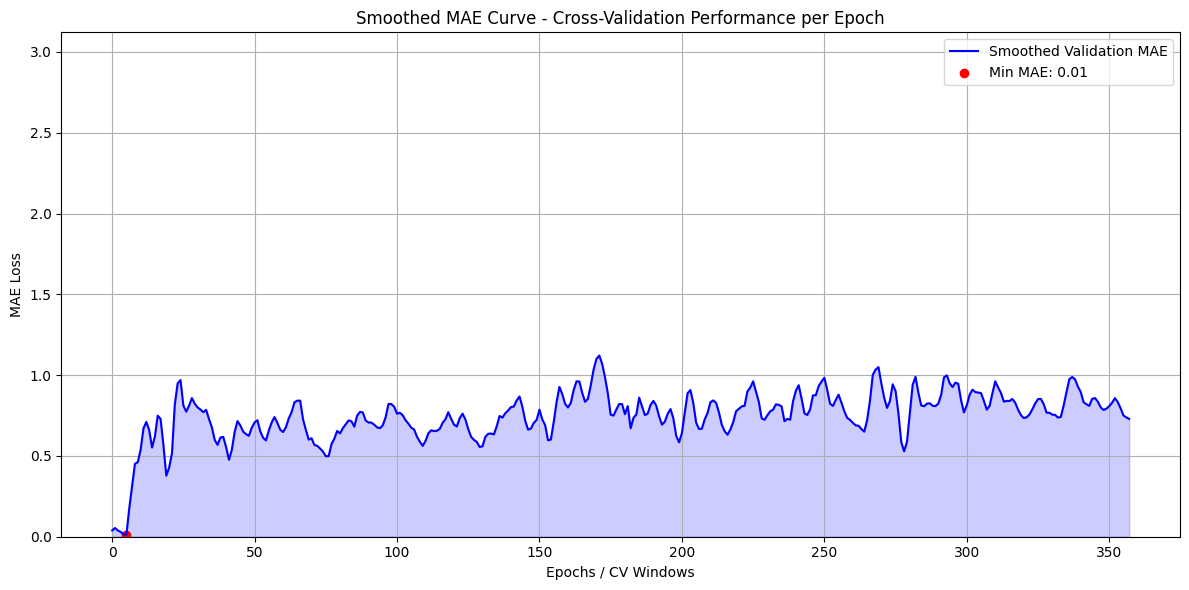

In [ ]:
# Calcolo MAE per ogni finestra della cross-validation
epoch_mae = cv_result.groupby('cutoff').apply(
    lambda g: mae(g['y'], g['Informer'])
).reset_index(name='mae_loss')

# Applicazione dello smoothing alla MAE
epoch_mae['mae_smooth'] = epoch_mae['mae_loss'].rolling(window=3, min_periods=1).mean()

# Plot MAE smussata
plt.figure(figsize=(12, 6))
plt.plot(epoch_mae['mae_smooth'], color='blue', label='Smoothed Validation MAE')
plt.fill_between(epoch_mae.index, epoch_mae['mae_smooth'], alpha=0.2, color='blue')

# Trovo il minimo
min_idx = epoch_mae['mae_smooth'].idxmin()
min_val = epoch_mae['mae_smooth'].min()
plt.scatter(min_idx, min_val, color='red', label=f'Min MAE: {min_val:.2f}')

plt.title('Smoothed MAE Curve - Cross-Validation Performance per Epoch')
plt.xlabel('Epochs / CV Windows')
plt.ylabel('MAE Loss')
plt.ylim(0, epoch_mae['mae_smooth'].max() + 2)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('mae_crossval_plot.png', dpi=300)
plt.show()

# **Personalized Fitness Recommender System**

Sulla base delle predizioni fornite dal modello Informer per l'activity_index del giorno successivo, è stato integrato un sistema di raccomandazione personalizzato per ciascun utente, con l'obiettivo di migliorare il benessere attraverso suggerimenti mirati su sonno e attività fisica, come ad esempio:

- Dormi più a lungo
- Fai più attività fisica
- Riduci i risvegli notturni

In [ ]:
def detailed_fitness_recommendation(row):
    # Restituisce una raccomandazione personalizzata basata sull'activity_index e i fattori deboli.
    index = row['activity_index']
    feedback = []

    if pd.isna(row['sleepduration']) or row['sleepduration'] < 6:
        feedback.append("dormi di pi\u00f9")
    if pd.isna(row['activity_duration']) or row['activity_duration'] / 60 < 30:
        feedback.append("fai pi\u00f9 attivit\u00e0 fisica")
    if pd.isna(row['awakeduration']) or row['awakeduration'] > 1:
        feedback.append("riduci i risvegli notturni")
    if pd.isna(row['deepduration']) or row['deepduration'] < 1:
        feedback.append("aumenta il sonno profondo")
    if pd.isna(row['remduration']) or not (1 <= row['remduration'] <= 2):
        feedback.append("ottimizza la fase REM")
    if pd.isna(row['stepsgaitspeed']) or row['stepsgaitspeed'] <= 100:
        feedback.append("cammina a passo pi\u00f9 sostenuto")
    if pd.isna(row['distancegaitspeed']) or row['distancegaitspeed'] <= 2:
        feedback.append("aumenta la distanza percorsa")
    if pd.isna(row['activity_calories']) or row['activity_calories'] <= 100:
        feedback.append("brucia pi\u00f9 calorie")

    # Messaggio base in base all'index
    if index >= 8:
        base_msg = "Ottimo lavoro! Continua cos\u00ec."
    elif 6 <= index < 8:
        base_msg = "Buon livello, ma c'\u00e8 margine di miglioramento."
    elif 4 <= index < 6:
        base_msg = "Livello moderato. Attenzione:"
    else:
        base_msg = "Livello basso. Consigliato intervenire su:"

    if feedback:
        return f"{base_msg} {', '.join(feedback[:3])}."
    else:
        return base_msg

Per generare raccomandazioni personalizzate, le previsioni dell'activity index sono state arricchite con le feature originali del dataset tramite un'operazione di merge sui campi user_id e data. Questo ha permesso di associare a ciascuna previsione informazioni reali come la durata del sonno o le calorie bruciate, fondamentali per applicare una funzione di raccomandazione dettagliata e fornire suggerimenti specifici per il benessere dell’utente.

In [ ]:
# Unione forecast + dati reali per avere accesso alle feature necessarie
forecast_with_features = pd.merge(
    forecast,
    dataset.reset_index(),
    left_on=['unique_id', 'ds'],
    right_on=['user_id', 'date'],
    how='left'
)

# Applicazione della funzione di raccomandazione dettagliata
forecast_with_features['recommendation'] = forecast_with_features.apply(detailed_fitness_recommendation, axis=1)

In [ ]:
#Visualizzazione di alcune raccomandazioni
import random
sample_users = random.sample(list(forecast_with_features['unique_id'].unique()), 5)

for user in sample_users:
    user_data = forecast_with_features[forecast_with_features['unique_id'] == user].sort_values('ds').tail(1)
    print(f"\nUtente: {user}")
    print(f"Data previsione: {user_data['ds'].dt.strftime('%Y-%m-%d').values[0]}")
    print(f"Activity Index previsto: {user_data['Informer'].values[0]:.2f}")
    print(f"Raccomandazione: {user_data['recommendation'].values[0]}")


Utente: 099d55d6eb3303810e96e406fed2fea0e26c11af
Data previsione: 2016-07-22
Activity Index previsto: 5.74
Raccomandazione: Livello moderato. Attenzione: fai più attività fisica, ottimizza la fase REM, cammina a passo più sostenuto.

Utente: dc4e93937bdef402a00b47fef7328215dcb0d46e
Data previsione: 2017-02-10
Activity Index previsto: 7.59
Raccomandazione: Buon livello, ma c'è margine di miglioramento. fai più attività fisica, ottimizza la fase REM, brucia più calorie.

Utente: 0331572cbb586fb502be3263d1e07f21e35a0130
Data previsione: 2017-03-31
Activity Index previsto: 5.29
Raccomandazione: Buon livello, ma c'è margine di miglioramento. fai più attività fisica, cammina a passo più sostenuto, brucia più calorie.

Utente: 98be2b501568345de48e3de0650d932e94ec9461
Data previsione: 2017-03-16
Activity Index previsto: 5.27
Raccomandazione: Livello moderato. Attenzione: dormi di più, fai più attività fisica, ottimizza la fase REM.

Utente: 5600d6d09dac6e0a5ad60dd5ce66f5c305cc95cf
Data previs

# **Creazione dei modelli per confronto con Informer e Valutazione**

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import DistributionLoss
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def run_model(model_class, model_name, target_col='activity_index'):
    print(f"\nAvvio addestramento del modello {model_name}...")

    # Inizializzazione del modello
    model = model_class(
        h=1,
        input_size=target_sequence_len * 3,
        learning_rate=1e-3,
        max_steps=500,
        val_check_steps=50,
        windows_batch_size=32,
        batch_size=32,
        loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
        early_stop_patience_steps=150,
        num_lr_decays=2,
        scaler_type='standard'
    )

    nf = NeuralForecast(models=[model], freq='D')
    nf.fit(df=train_df, val_size=1)

    forecast = nf.predict(df=test_df)
    print("Previsione completata!")

    # Conversioni e allineamento date/user
    forecast['unique_id'] = forecast['unique_id'].astype(str)
    forecast['ds'] = pd.to_datetime(forecast['ds'])

    dataset_copy = dataset.reset_index()
    dataset_copy['user_id'] = dataset_copy['user_id'].astype(str)
    dataset_copy['date'] = pd.to_datetime(dataset_copy['date'])
    dataset_copy = dataset_copy.set_index(['user_id', 'date'])

    # Recupero dei target reali
    true_targets = []
    for idx, row in forecast.iterrows():
        try:
            y_real = dataset_copy.loc[(row['unique_id'], row['ds']), target_col]
            y_real = y_real.iloc[0] if isinstance(y_real, pd.Series) else y_real
        except KeyError:
            y_real = np.nan
        true_targets.append({'unique_id': row['unique_id'], 'ds': row['ds'], 'y_real': y_real})

    real_targets_df = pd.DataFrame(true_targets)

    # Merge tra predizione e valore reale
    merged = pd.merge(forecast, real_targets_df, on=['unique_id', 'ds'], how='inner')
    merged = merged.dropna(subset=['y_real', model_name])
    print(f"\nRighe valide per il calcolo delle metriche: {merged.shape[0]}")

    # Metriche
    if merged.empty:
        print("Nessuna riga valida per il calcolo.")
    else:
        mse = mean_squared_error(merged['y_real'], merged[model_name])
        mae = mean_absolute_error(merged['y_real'], merged[model_name])
        rmse = np.sqrt(mse)
        r2 = r2_score(merged['y_real'], merged[model_name])

        print(f"\n RISULTATI MODELLO {model_name}")
        print(f"MSE:  {mse:.3f}")
        print(f"MAE:  {mae:.3f}")
        print(f"RMSE: {rmse:.3f}")
        print(f"R²:   {r2:.3f}")

    return merged


# **modello PatchTST**
Il PatchTST è un modello di deep learning di ultima generazione, progettato specificamente per il forecasting di serie temporali multivariate. A differenza dei modelli tradizionali, PatchTST suddivide le sequenze temporali in piccoli segmenti (patch), facilitando l’apprendimento di pattern locali e globali. Questa struttura lo rende particolarmente efficace su dataset complessi come quello utilizzato in questo progetto, dove sono presenti più variabili correlate (sonno, attività fisica, indice di attività). PatchTST sfrutta i punti di forza dei Transformer, migliorando la gestione di lunghe sequenze e riducendo il rischio di overfitting

In [ ]:
from neuralforecast.models import PatchTST
merged_patchtst = run_model(PatchTST, 'PatchTST')


INFO:lightning_fabric.utilities.seed:Seed set to 1



Avvio addestramento del modello PatchTST...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | DistributionLoss  | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 402 K  | train
-----------------------------------------------------------
402 K     Trainable params
8         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Previsione completata!

Righe valide per il calcolo delle metriche: 1272

 RISULTATI MODELLO PatchTST
MSE:  1.341
MAE:  0.880
RMSE: 1.158
R²:   0.354


# **modello Autoformer**
Autoformer è un modello avanzato basato su Transformer, progettato per il forecasting di serie temporali a lungo termine. La sua architettura introduce un meccanismo di autocorrelazione che consente di catturare le dipendenze periodiche nei dati in modo più efficiente. A differenza dei Transformer tradizionali, Autoformer elimina la necessità di posizioni assolute, concentrandosi invece sulla ripetitività intrinseca delle serie temporali. Questo approccio lo rende particolarmente adatto a scenari in cui i pattern ciclici, come quelli legati al sonno e all’attività fisica, giocano un ruolo centrale nella previsione dell’indice di benessere.

In [ ]:
from neuralforecast.models import Autoformer
merged_autoformer = run_model(Autoformer, 'Autoformer')

INFO:lightning_fabric.utilities.seed:Seed set to 1



Avvio addestramento del modello Autoformer...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | DistributionLoss | 5      | train
1 | padder_train  | ConstantPad1d    | 0      | train
2 | scaler        | TemporalNorm     | 0      | train
3 | decomp        | SeriesDecomp     | 0      | train
4 | enc_embedding | DataEmbedding    | 384    | train
5 | dec_embedding | DataEmbedding    | 384    | train
6 | encoder       | Encoder          | 148 K  | train
7 | decoder       | Decoder          | 142 K  | train
-----------------------------------------------------------
291 K     Trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Previsione completata!

Righe valide per il calcolo delle metriche: 1272

 RISULTATI MODELLO Autoformer
MSE:  1.983
MAE:  1.006
RMSE: 1.408
R²:   0.045


# **modello NHITS**
NHITS (Neural Hierarchical Interpolation for Time Series) è un modello MLP-based che adotta un approccio gerarchico per la ricostruzione delle serie temporali. Utilizza una struttura a blocchi progressivi per approssimare il segnale target attraverso raffinamenti successivi, riducendo l’errore di previsione a ogni passaggio. NHITS si distingue per l'efficienza computazionale e la robustezza alle fluttuazioni dei dati.

In [ ]:
from neuralforecast.models import NHITS
merged_nhits = run_model(NHITS, 'NHITS')

INFO:lightning_fabric.utilities.seed:Seed set to 1



Avvio addestramento del modello NHITS...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 2.5 M  | train
----------------------------------------------------------
2.5 M     Trainable params
5         Non-trainable params
2.5 M     Total params
9.944     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Previsione completata!

Righe valide per il calcolo delle metriche: 1272

 RISULTATI MODELLO NHITS
MSE:  2.739
MAE:  1.153
RMSE: 1.655
R²:   -0.319


# **modello TimesNet**
TimesNet è un modello basato su convoluzioni gerarchiche pensato per il forecasting di serie temporali univariate e multivariate. Introduce un nuovo paradigma che sfrutta kernel convoluzionali a diversi livelli per catturare dinamiche temporali a scala multipla. Grazie alla sua capacità di apprendere rappresentazioni temporali ricche ed efficienti, TimesNet si adatta bene a serie complesse e rumorose.

In [ ]:
from neuralforecast.models import TimesNet
merged_nhits = run_model(TimesNet, 'TimesNet')

INFO:lightning_fabric.utilities.seed:Seed set to 1



Avvio addestramento del modello TimesNet...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | loss           | DistributionLoss | 5      | train
1 | padder_train   | ConstantPad1d    | 0      | train
2 | scaler         | TemporalNorm     | 0      | train
3 | model          | ModuleList       | 4.7 M  | train
4 | enc_embedding  | DataEmbedding    | 192    | train
5 | layer_norm     | LayerNorm        | 128    | train
6 | predict_linear | Linear           | 2.1 K  | train
7 | projection     | Linear           | 195    | train
------------------------------------------------------------
4.7 M  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Previsione completata!

Righe valide per il calcolo delle metriche: 1272

 RISULTATI MODELLO TimesNet
MSE:  1.906
MAE:  0.989
RMSE: 1.381
R²:   0.082


# **Conclusione**


Dal confronto finale tra i modelli testati emerge che Informer rappresenta la soluzione più efficace per la previsione dell’activity_index, grazie a prestazioni complessive superiori su tutte le metriche considerate. In particolare, Informer ottiene il MSE più basso (0.923), il MAE più contenuto (0.702) e il valore più alto di R² (0.555), evidenziando una maggiore precisione e una migliore capacità di spiegare la variabilità del target rispetto agli altri modelli.

A confronto, PatchTST mostra performance solide (MSE = 1.341, MAE = 0.880, R² = 0.354), ma meno efficaci nel catturare le dinamiche temporali complesse del dataset. Anche modelli più recenti come TimesNet (MSE = 1.906, MAE = 0.989, R² = 0.082) e Autoformer (MSE = 1.983, MAE = 1.006) non riescono a raggiungere gli stessi livelli di accuratezza. Infine, NHITS risulta il meno performante tra quelli testati, con un MSE di 2.739 e un MAE di 1.153.

Nel complesso, l’architettura di Informer si dimostra particolarmente adatta al contesto multivariato e alle forti dipendenze temporali del problema analizzato, confermandosi come il modello più robusto e affidabile tra quelli sperimentati.